In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
import json
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer, TokenizedResult
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "052"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = False

expected_tokens = 300  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.3)
wandb.config["lr"] = lr = 1e-5
wandb.config["betas"] = betas = (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2
prev_deferred_results: list[list[TokenizedResult]] | None = None

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8003 --api-key=default
INFO 02-26 16:22:40 __init__.py:190] Automatically detected platform cuda.
INFO 02-26 16:22:40 api_server.py:840] vLLM API server version 0.7.2
INFO 02-26 16:22:40 api_server.py:841] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8003, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=No

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  5.84it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:01,  1.99it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.58it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.44it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.61it/s]



INFO 02-26 16:22:55 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-26 16:22:56 worker.py:267] Memory profiling takes 0.93 seconds
INFO 02-26 16:22:56 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-26 16:22:56 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-26 16:22:56 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-26 16:22:56 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-26 16:23:42 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.71 seconds
INFO 02-26 16:23:43 api_server.py:756] Using supplied chat template:
INFO 02-26 16:23:43 api_server.py:756] None
INFO 02-26 16:23:43 launcher.py:21] Available routes are:
INFO 02-26 16:23:43 launcher.py:29] Route: /

INFO:     Started server process [76875]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)


INFO 02-26 16:23:46 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45350 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:37<00:00,  1.85it/s, completion_tokens=326, prompt_tokens=1375, reward=0.208, acc=0.208, early_stop=0.000313, token_logprobs=1042131]


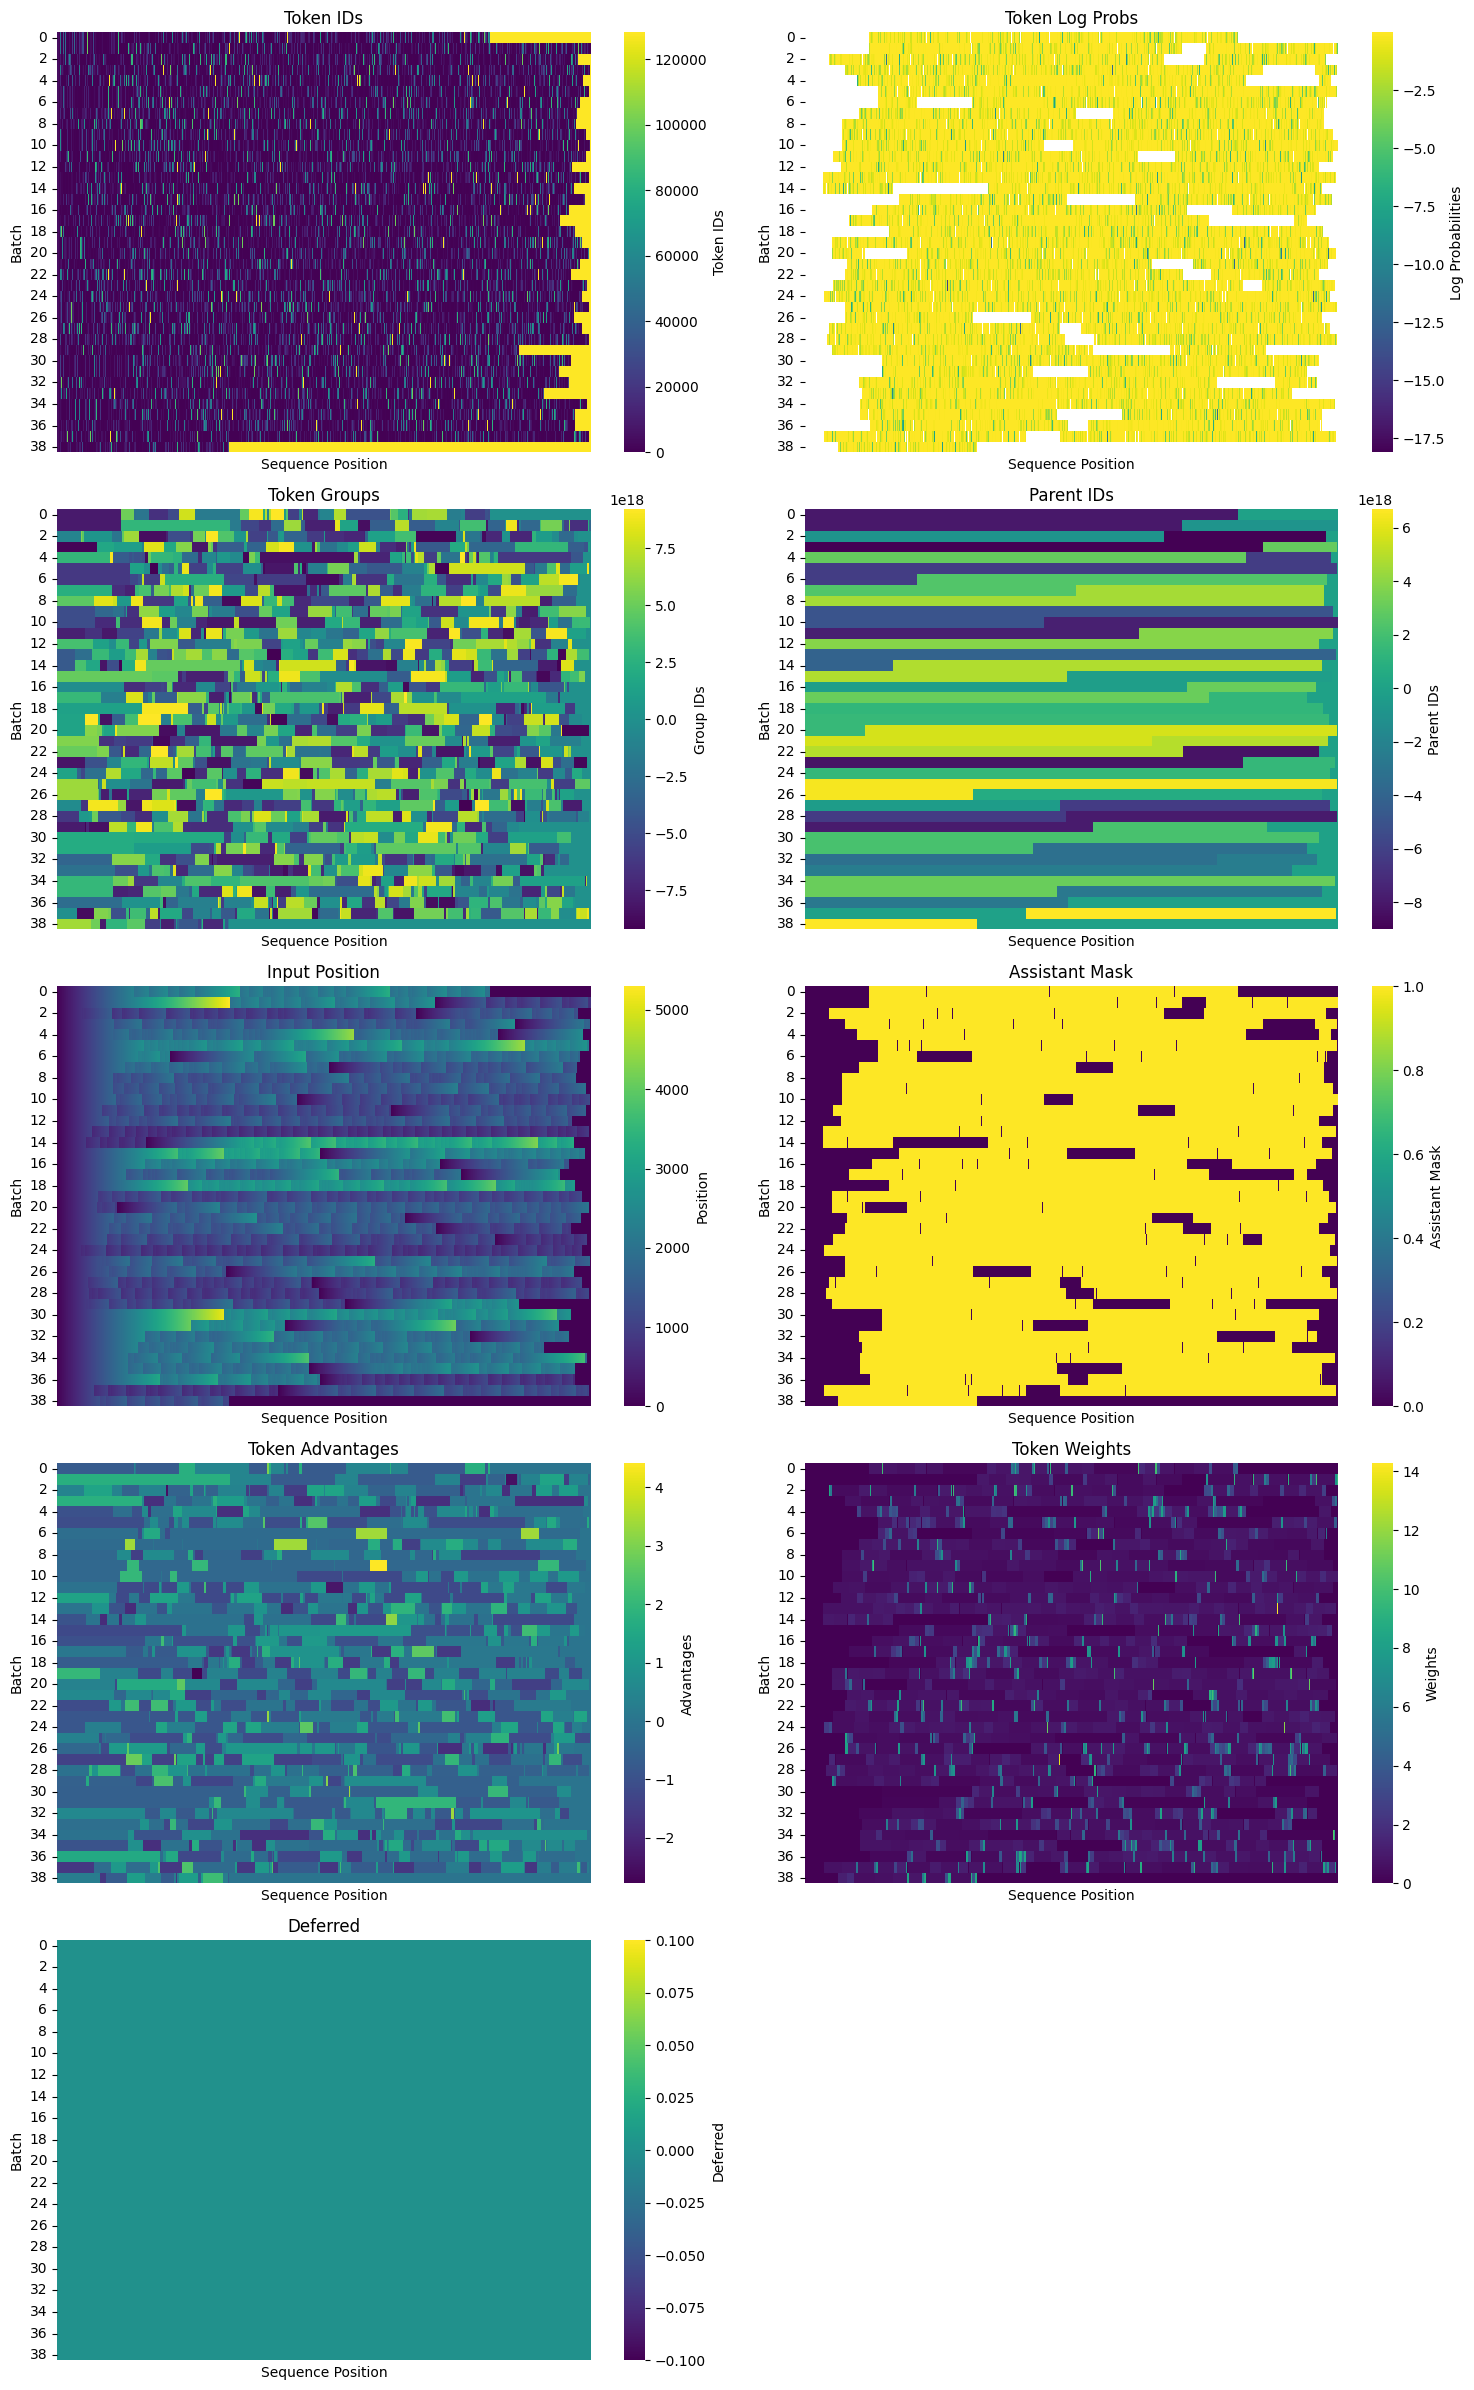

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/052/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - model-00004-of-00004.safetensors
  - model-00003-of-00004.safetensors
  - model-00002-of-00004.safetensors
  - model-00001-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/052
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/052/tensors
  num_sequences: 39
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulatio

Writing logs to models/052/logs/log_1740587274.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.17 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: 0.0332: 100%|██████████| 1/1 [07:03<00:00, 423.33s/it, loss=0.0332, policy=0.0332, entropy=0.584, kl_div=nan, grad_magnitude=3.98]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model

rsyncing /home/gcpuser/sky_workdir/experiments/models/052 to gs:/atreides/openpipe/models/052
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/052/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/052/0001 --port=8003 --api-key=default
INFO 02-26 16:35:57 __init__.py:190] Automatically detected platform cuda.
INFO 02-26 16:35:58 api_server.py:840] vLLM API server version 0.7.2
INFO 02-26 16:35:58 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/052/0001', config='', host=None, port=8003, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=No

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.33it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.28it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.87it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.57it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.54it/s]



INFO 02-26 16:36:12 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-26 16:36:13 worker.py:267] Memory profiling takes 1.03 seconds
INFO 02-26 16:36:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-26 16:36:13 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-26 16:36:13 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-26 16:36:13 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-26 16:37:01 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.84 seconds
INFO 02-26 16:37:02 api_server.py:756] Using supplied chat template:
INFO 02-26 16:37:02 api_server.py:756] None
INFO 02-26 16:37:02 launcher.py:21] Available routes are:
INFO 02-26 16:37:02 launcher.py:29] Route: /

INFO:     Started server process [82644]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)


INFO 02-26 16:37:04 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:49624 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:30<00:00, 81.16it/s, completion_tokens=38, prompt_tokens=1227, reward=0.307, acc=0.307, token_logprobs=120719]


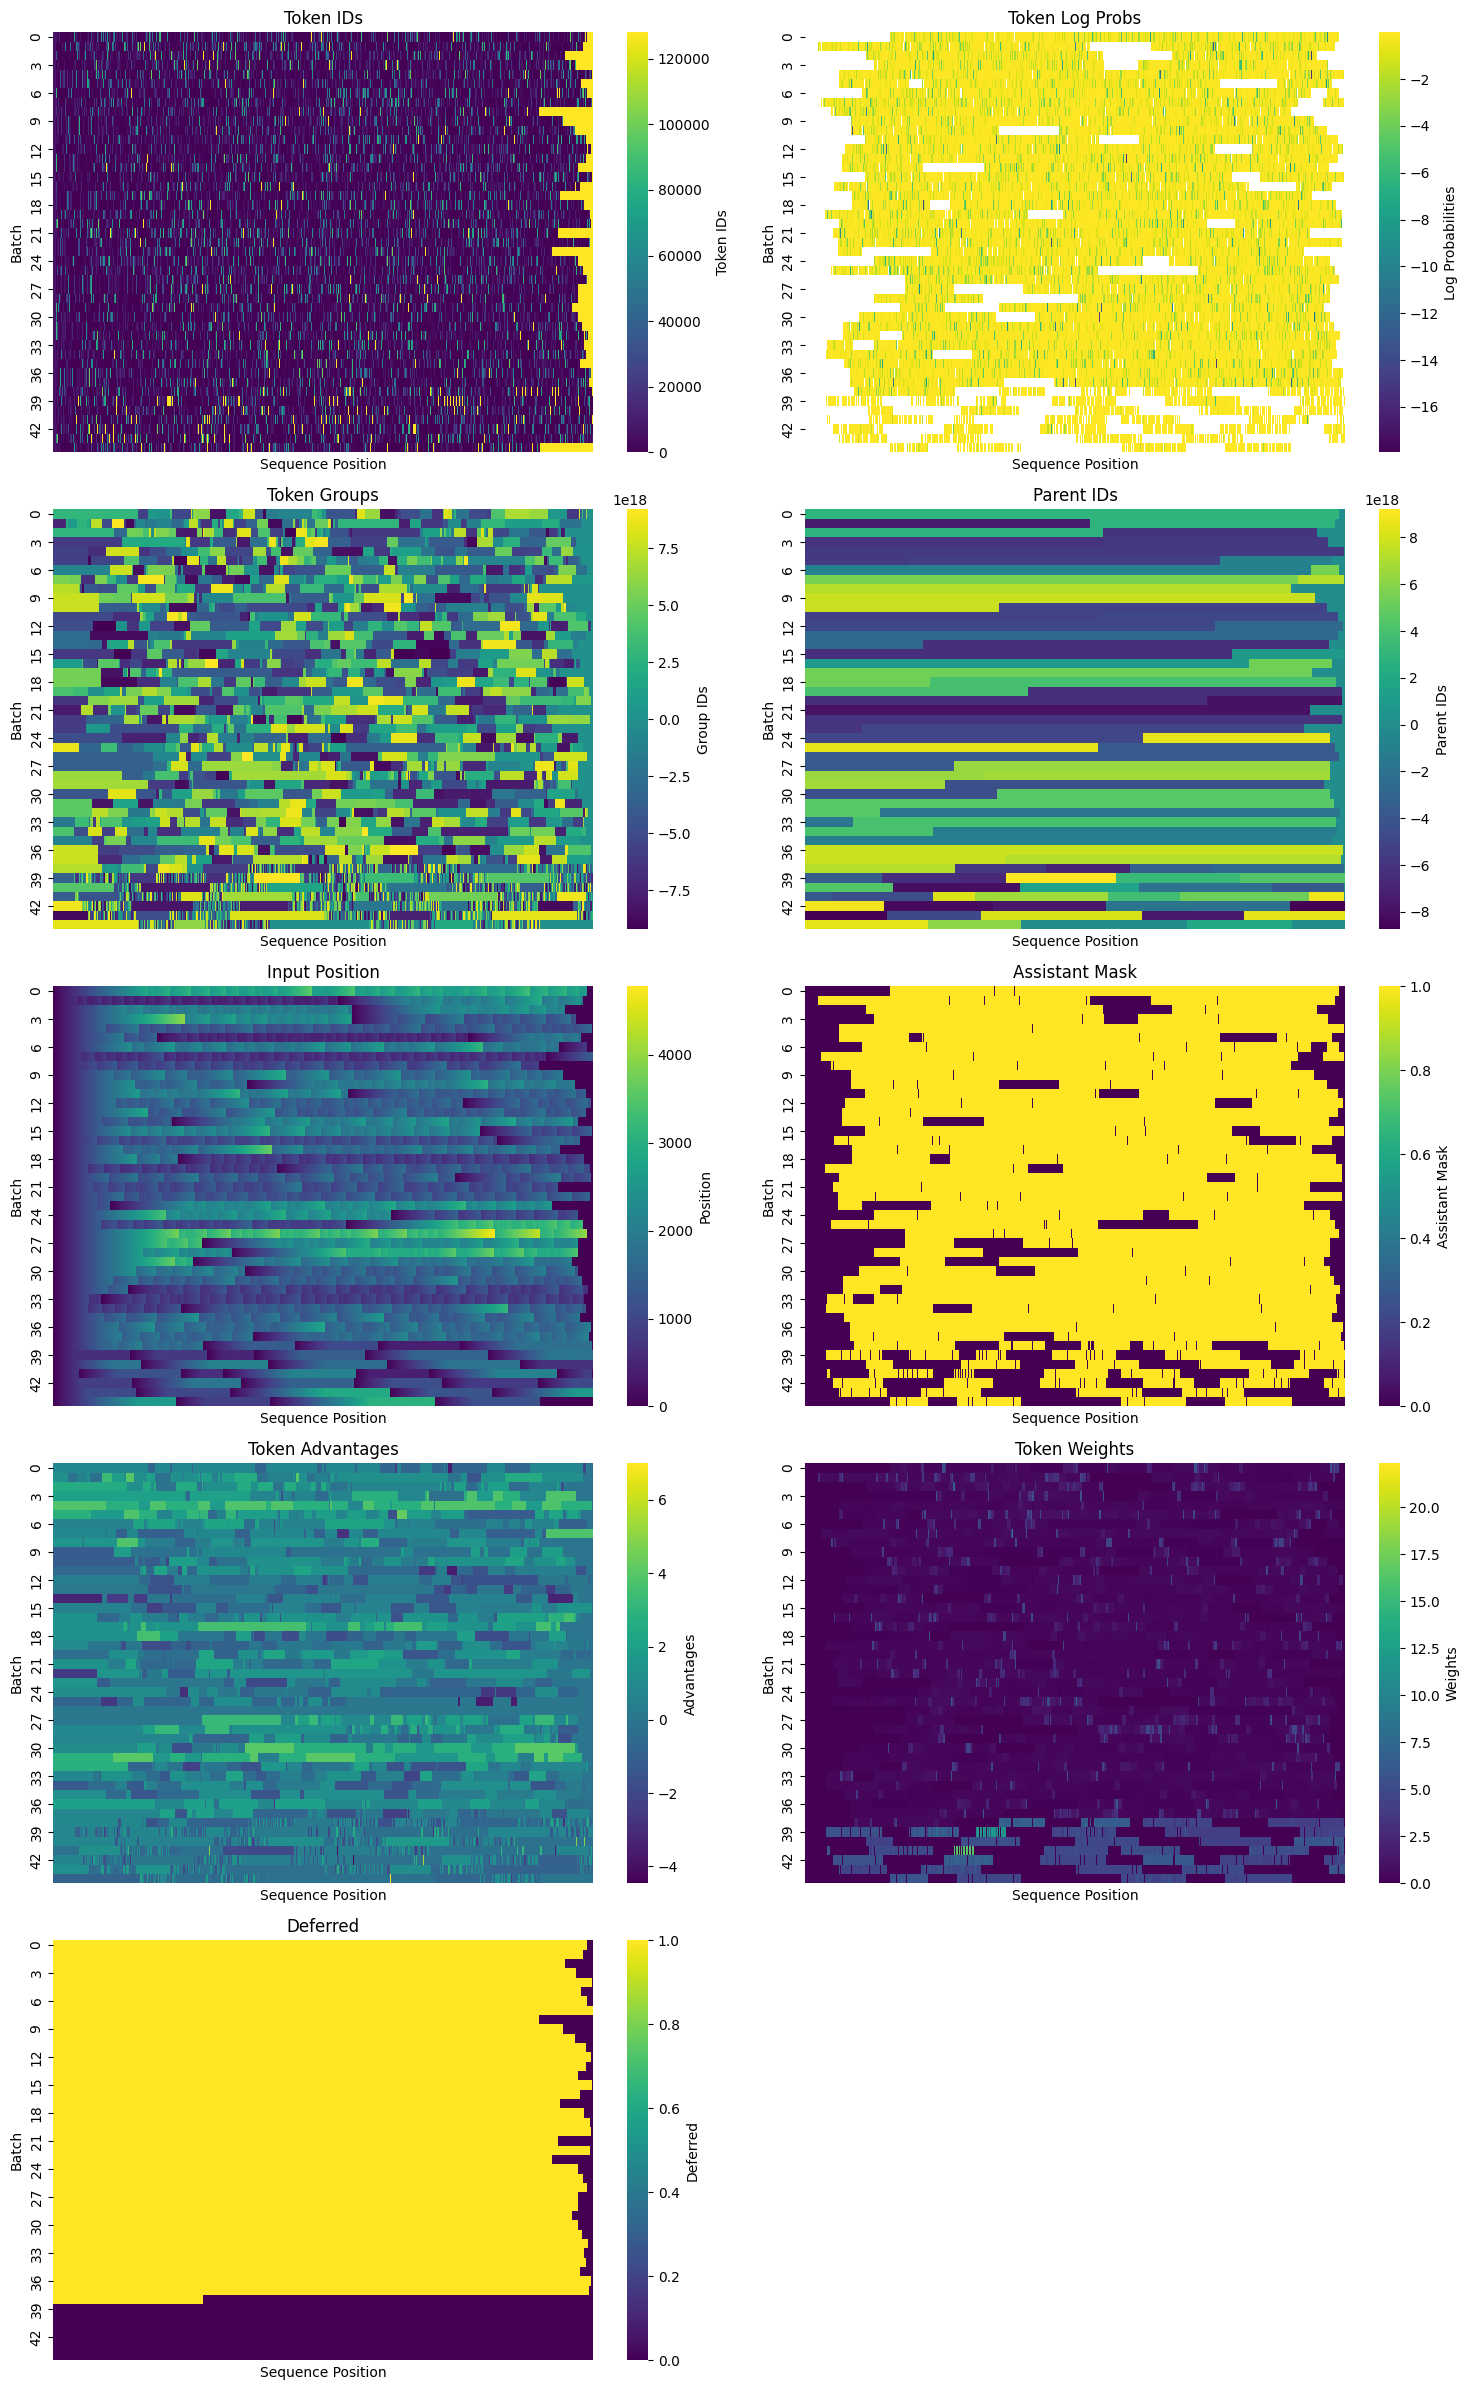

rsyncing /home/gcpuser/sky_workdir/experiments/models/052 to gs:/atreides/openpipe/models/052
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/052/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/052/0001
  checkpoint_files:
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/052
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/052/tensors
  num_sequences: 45
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 20
log_grad_magnitude: true
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef

Writing logs to models/052/logs/log_1740587943.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.34 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: 0.1002: 100%|██████████| 1/1 [08:18<00:00, 498.60s/it, loss=0.1, policy=0.1, entropy=0.202, kl_div=nan, grad_magnitude=40.5]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state

rsyncing /home/gcpuser/sky_workdir/experiments/models/052 to gs:/atreides/openpipe/models/052
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/052/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/052/0002 --port=8003 --api-key=default
INFO 02-26 16:48:23 __init__.py:190] Automatically detected platform cuda.
INFO 02-26 16:48:24 api_server.py:840] vLLM API server version 0.7.2
INFO 02-26 16:48:24 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/052/0002', config='', host=None, port=8003, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=No

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.35it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.29it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.87it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.57it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.55it/s]



INFO 02-26 16:48:38 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-26 16:48:39 worker.py:267] Memory profiling takes 1.08 seconds
INFO 02-26 16:48:39 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-26 16:48:39 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-26 16:48:39 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-26 16:48:39 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-26 16:49:28 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 50.53 seconds
INFO 02-26 16:49:29 api_server.py:756] Using supplied chat template:
INFO 02-26 16:49:29 api_server.py:756] None
INFO 02-26 16:49:29 launcher.py:21] Available routes are:
INFO 02-26 16:49:29 launcher.py:29] Route: /

INFO:     Started server process [90718]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)


INFO 02-26 16:49:34 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55960 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [05:25<00:00, 89.08it/s, completion_tokens=40, prompt_tokens=1168, reward=0.308, acc=0.308, token_logprobs=127145]
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no uniq

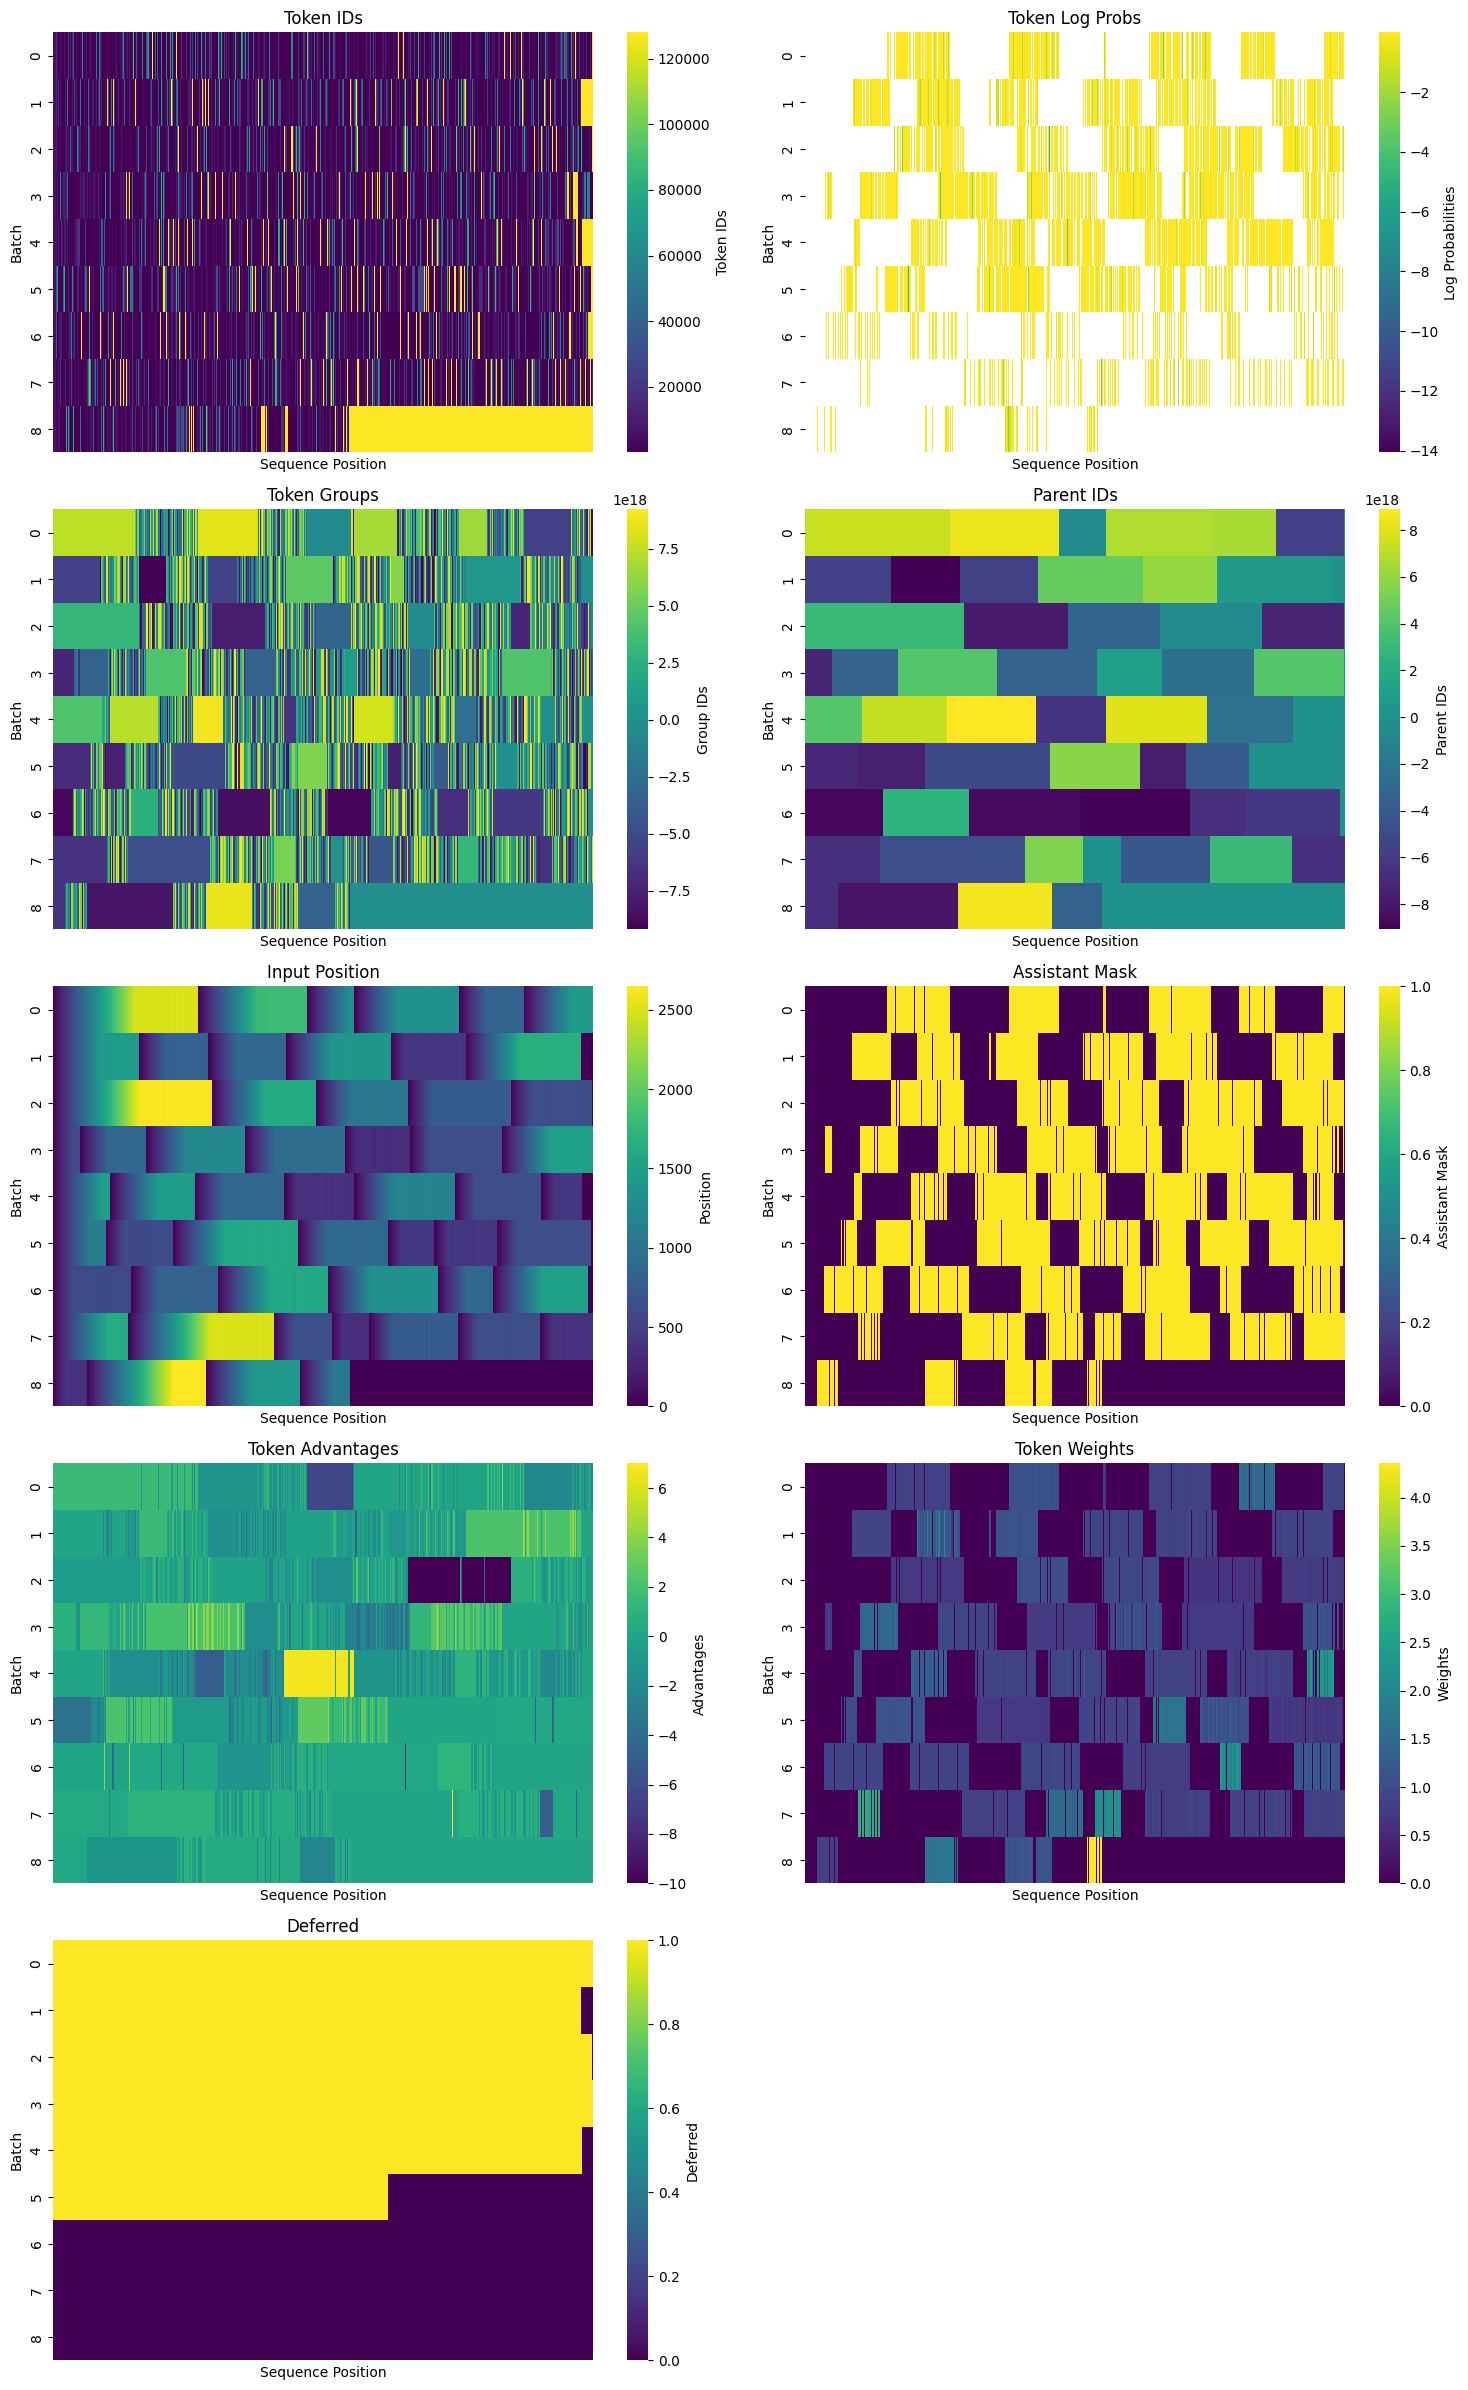

rsyncing /home/gcpuser/sky_workdir/experiments/models/052 to gs:/atreides/openpipe/models/052
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/052/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/052/0002
  checkpoint_files:
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/052
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/052/tensors
  num_sequences: 9
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 2
log_grad_magnitude: true
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 

Writing logs to models/052/logs/log_1740588924.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 19.24 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|1|Loss: -0.0314: 100%|██████████| 1/1 [00:54<00:00, 54.38s/it, loss=-0.0314, policy=-0.0314, entropy=0.0164, kl_div=nan, grad_magnitude=836]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full mod

rsyncing /home/gcpuser/sky_workdir/experiments/models/052 to gs:/atreides/openpipe/models/052
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/052/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/052/0003 --port=8003 --api-key=default
INFO 02-26 16:57:19 __init__.py:190] Automatically detected platform cuda.
INFO 02-26 16:57:20 api_server.py:840] vLLM API server version 0.7.2
INFO 02-26 16:57:20 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/052/0003', config='', host=None, port=8003, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=No

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.34it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.28it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.86it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.59it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.56it/s]



INFO 02-26 16:57:34 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-26 16:57:35 worker.py:267] Memory profiling takes 0.95 seconds
INFO 02-26 16:57:35 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-26 16:57:35 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-26 16:57:35 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-26 16:57:35 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-26 16:58:25 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 50.32 seconds
INFO 02-26 16:58:25 api_server.py:756] Using supplied chat template:
INFO 02-26 16:58:25 api_server.py:756] None
INFO 02-26 16:58:25 launcher.py:21] Available routes are:
INFO 02-26 16:58:25 launcher.py:29] Route: /

INFO:     Started server process [97576]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)


INFO 02-26 16:58:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42518 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:40<00:00, 48.05it/s, completion_tokens=44, prompt_tokens=1142, reward=0.255, acc=0.255, token_logprobs=140710]
Deleted iteration directory ./models/052/0002


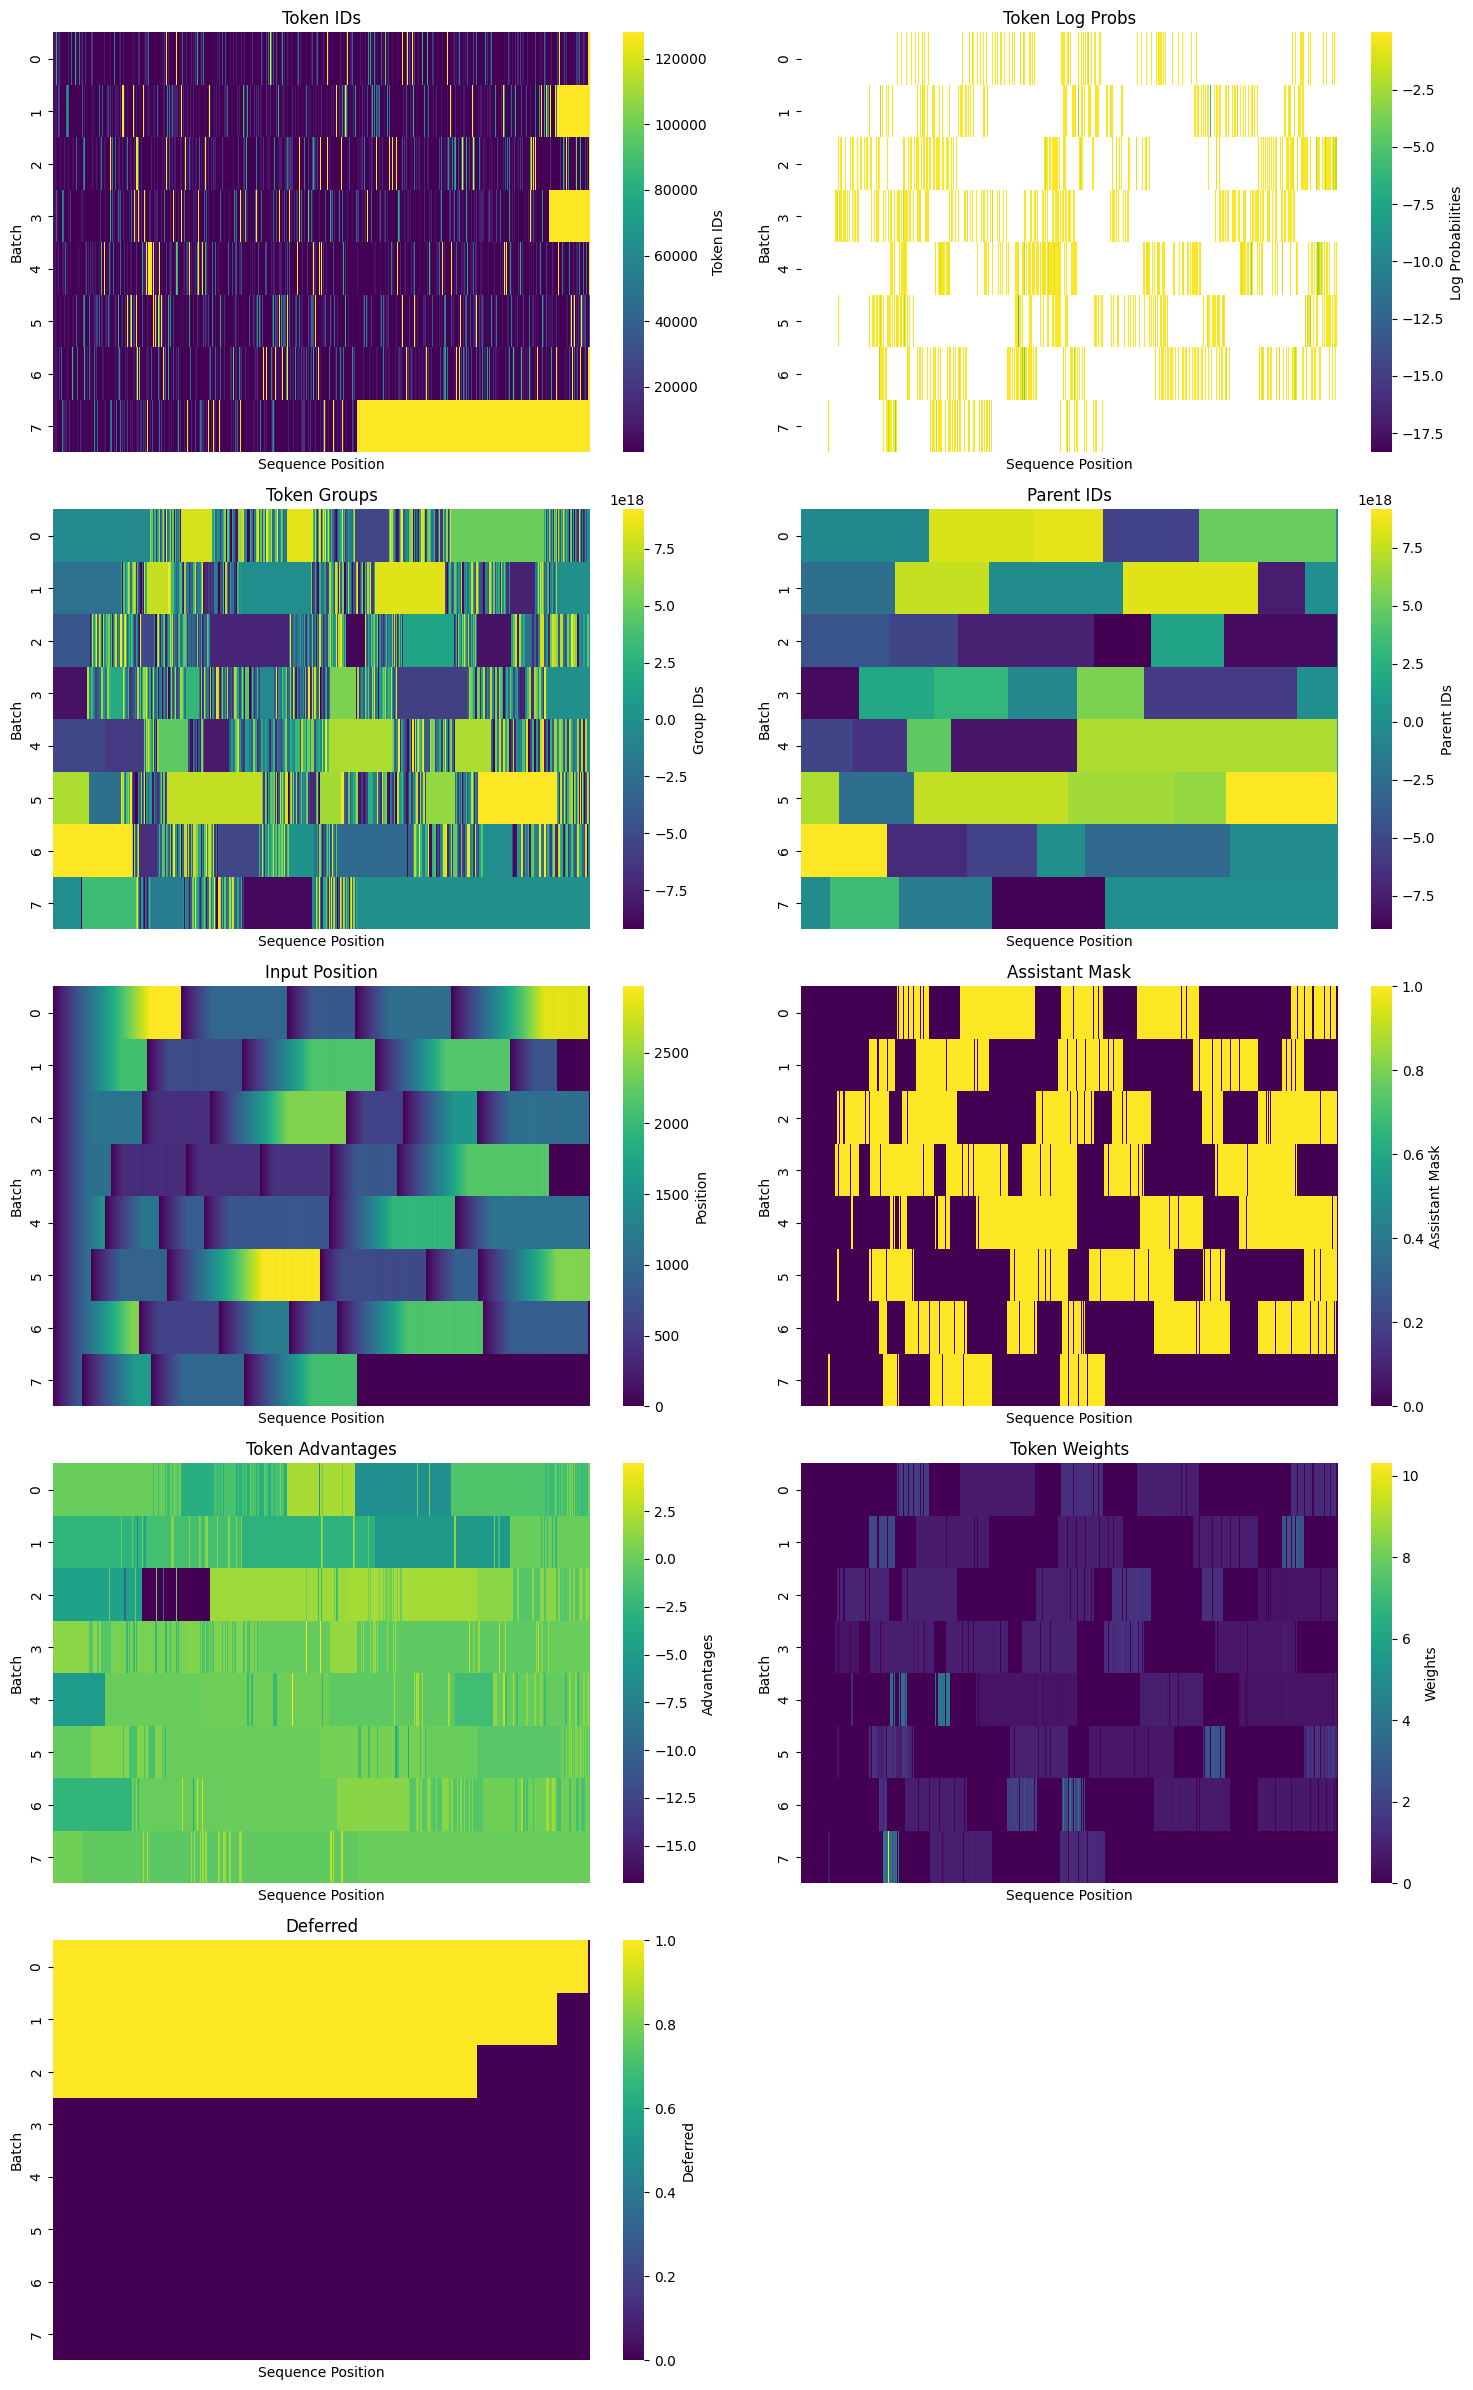

rsyncing /home/gcpuser/sky_workdir/experiments/models/052 to gs:/atreides/openpipe/models/052
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/052/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/052/0003
  checkpoint_files:
  - ft-model-00002-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/052
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/052/tensors
  num_sequences: 8
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 2
log_grad_magnitude: true
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 

Writing logs to models/052/logs/log_1740589234.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 54.34 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
  0%|          | 0/1 [00:00<?, ?it/s]

AssertionError: No epoch directory found in output directory ./models/052

In [5]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=240 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
        # see ./logs/rsync.log for output
        asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))
    except Exception:
        pass
    # Deferred results
    train_results, deferred_results = (
        train_results[: len(train_results) // 2],
        train_results[len(train_results) // 2 :],
    )
    if prev_deferred_results is not None:
        for _deferred_results, _train_results in zip(
            prev_deferred_results, train_results
        ):
            mean_reward = (
                torch.tensor([result.reward for result in _train_results]).mean().item()
            )
            differences = [mean_reward - result.reward for result in _deferred_results]
            std_dev = torch.std(torch.tensor(differences)).item()
            for result, difference in zip(_deferred_results, differences):
                result.advantage = difference / std_dev if std_dev > 1e-2 else 0.0
                result.deferred = True
        random.shuffle(prev_deferred_results)
        random.shuffle(train_results)
        train_results = prev_deferred_results + train_results
    else:
        random.shuffle(train_results)
    prev_deferred_results = deferred_results
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    batch_size = model.tune_max_batch_tokens // seq_len
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            gradient_accumulation_steps=max(
                packed_tensors["tokens"].shape[0] // batch_size - batch_size, 1
            ),
            max_steps_per_epoch=1,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=False,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=model.tune_num_output_chunks,
            compile=True,
            log_grad_magnitude=True,
        ),
        verbosity=verbosity,
    )
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/", output_dir))